In [43]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cmocean.cm as cm
import shapely.geometry
from matplotlib.patches import Polygon as MatplotlibPolygon
import geopandas as gpd
from scipy.optimize import curve_fit
from scipy import signal

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from salishsea_tools import viz_tools

# Goal
Turn model results for 2019 into something that shows the spatial and temporal distributions of scrubber washwater in the Salish Sea. We were going to do 3 dyes with different half-lives, so I will probably have this notebook as the master notebook and then make two others for the different dyes.

Our parameter of interest is washwater concentration. We can use the concentrations reported in Hermansson et al. and the initial report (cite) to set contours of washwater concentration.

In [24]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
volume = ((1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth'})

In [25]:
## read in the input washwater file
ww_in = xr.open_dataset('/ocean/cdonaldson/scrubbers/yearly_obs/scrubber_1d_obs_tempsalcalc_20190101_20191231.nc')

In [26]:
## read in the year of results and select which washwater parameter to look at
ww_out = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19_nn/SalishSea_1d_20190101_20190630_scrb_T.nc')
ww_out_p2 = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jul19_nn/SalishSea_1d_20190701_20191231_scrb_T.nc')
# ww_out = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19/SalishSea_1d_20190101_20190630_scrb_T.nc')
# ww_out_oneday = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19_oneday_green/SalishSea_1d_20190101_20190101_scrb_T.nc')
ww_out_oneday = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/nonan_blue/SalishSea_1d_20190101_20190101_scrb_T.nc')

In [27]:
ww_accumulated = xr.open_dataset('/ocean/cdonaldson/scrubbers/calcs/SalishSea_1d_20190101_20191231_scrb_T_accumulation.nc')

### Initial Scratch

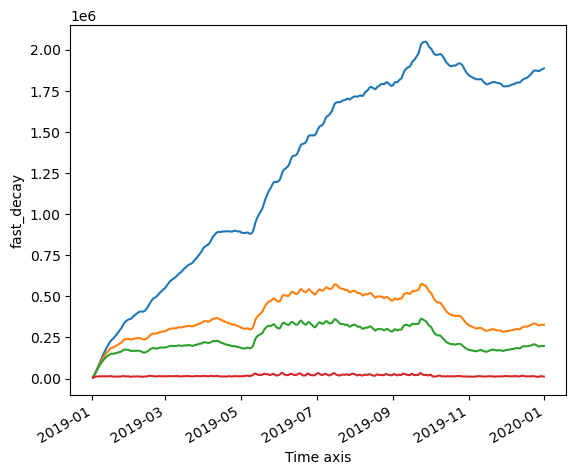

In [28]:
ww_accumulated['no_decay'].plot()
ww_accumulated['slow_decay'].plot()
ww_accumulated['medium_decay'].plot()
ww_accumulated['fast_decay'].plot()

In [29]:
ww_in_sum = ww_in.washwater.sum(dim='gridY').sum(dim='gridX')

In [30]:
ww_in_cumsum = ww_in_sum.cumsum()

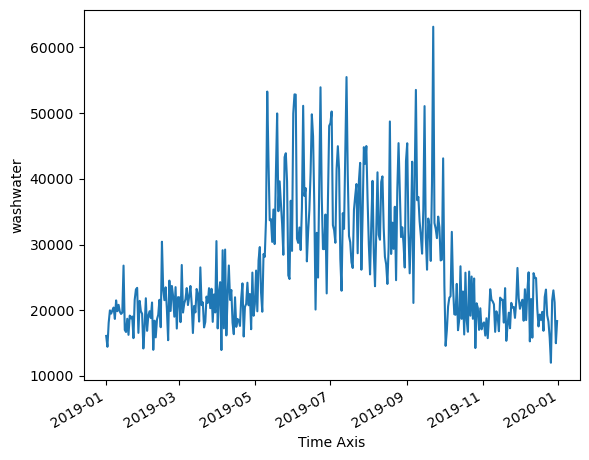

In [31]:
ww_in_sum.plot()

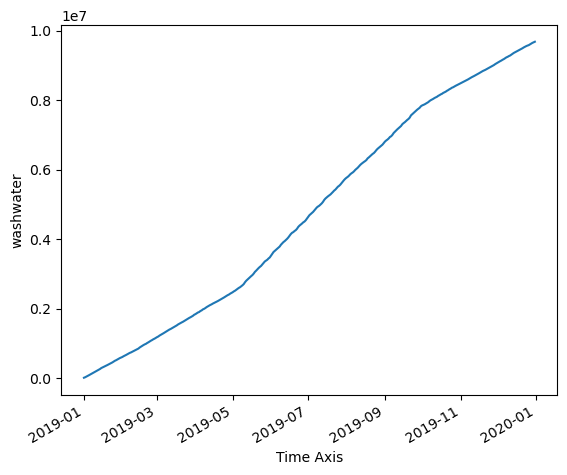

In [32]:
ww_in_cumsum.plot()

Text(0, 0.5, 'm3')

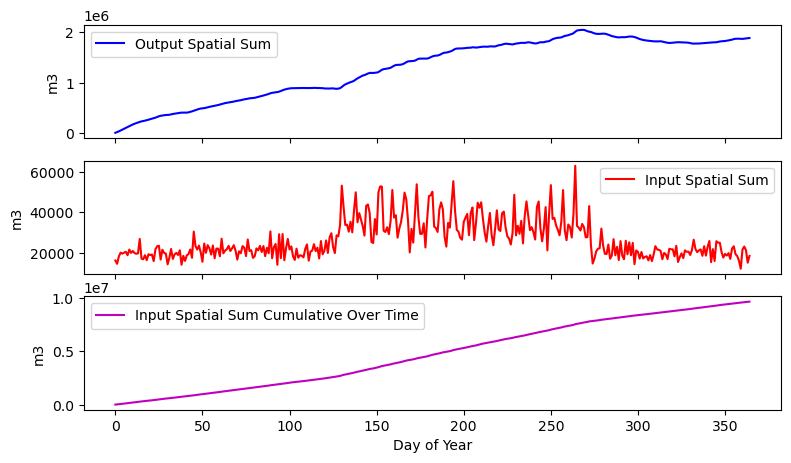

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(9, 5), sharex=True)

ax[0].plot(np.arange(len(ww_accumulated['no_decay'])), ww_accumulated['no_decay'], label='Output Spatial Sum', c='b')
ax[0].legend()
ax[0].set_ylabel('m3')

ax[1].plot(np.arange(len(ww_in_sum)), ww_in_sum, label='Input Spatial Sum', c='r')
ax[1].legend()
ax[1].set_ylabel('m3')

ax[2].plot(np.arange(len(ww_in_cumsum)), ww_in_cumsum, label='Input Spatial Sum Cumulative Over Time', c='m')
ax[2].legend()
ax[2].set_xlabel('Day of Year')
ax[2].set_ylabel('m3')

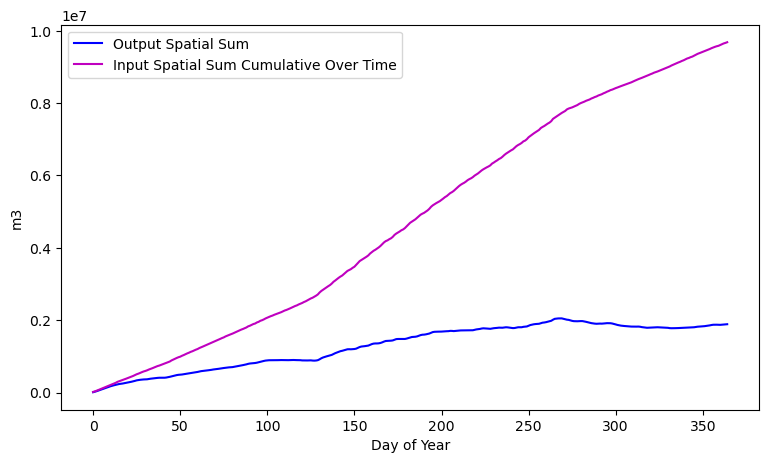

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 5), sharex=True)

ax1.plot(np.arange(len(ww_accumulated['no_decay'])), ww_accumulated['no_decay'], label='Output Spatial Sum', c='b')
ax1.set_ylabel('m3')

ax1.plot(np.arange(len(ww_in_cumsum)), ww_in_cumsum, label='Input Spatial Sum Cumulative Over Time', c='m')
ax1.set_xlabel('Day of Year')
ax1.legend()

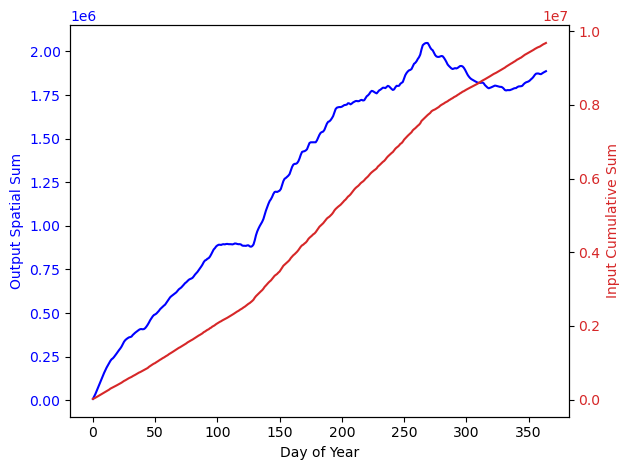

In [35]:
fig, ax1 = plt.subplots()

color = 'b'
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Output Spatial Sum', color=color)
ax1.plot(np.arange(len(ww_accumulated['no_decay'])), ww_accumulated['no_decay'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Input Cumulative Sum', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(ww_in_cumsum)), ww_in_cumsum, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Steady State?

In [45]:
def days_vols(idxs, ds, var):
    days = [ds['time_counter'][idxs[0]], ds['time_counter'][idxs[1]], ds['time_counter'][idxs[2]]]
    vols = [ds[var][idxs[0]], ds[var][idxs[1]], ds[var][idxs[2]]]
    return days, vols

In [42]:
def resample_mean(arr, chunk_size):
    if len(arr) % chunk_size != 0:
        raise ValueError("Array length must be divisible by chunk size")

    num_chunks = len(arr) // chunk_size
    return np.mean(arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size), axis=1)

In [37]:
def model(t, A, T):
    return A * (1 - np.exp(-t / T))

def model_inv(y, A, T):
    return -T * np.log(1 - (y/A))

In [38]:
def fit_and_plot(initial_guess, t_data, Y_data, region):
    popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
    A_opt, T_opt = popt

    T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
    T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
    T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)
    T_99pct = model_inv(A_opt*0.99, A_opt, T_opt)

    print("Optimized parameters:")
    print("A = {:.0f} m^3".format(A_opt))
    print("T = {:.0f} days, {:.2f} years".format(T_opt, T_opt/365))
    print('T_80pct = {:.2f} years'.format(T_80pct/365))
    print('T_90pct = {:.2f} years'.format(T_90pct/365))
    print('T_95pct = {:.2f} years'.format(T_95pct/365))
    print('T_99pct = {:.2f} years'.format(T_99pct/365))

    # Generate the fitted curve
    t_fit = np.linspace(0, max(t_data)*2, 100)
    Y_fit = model(t_fit, A_opt, T_opt)

    # Plot the original data and the fitted curve
    plt.plot(t_data, Y_data, 'bo', label='Data')
    plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
    plt.vlines([T_opt, T_80pct, T_90pct, T_95pct, T_99pct], [0, 0, 0, 0, 0], [A_opt, A_opt, A_opt, A_opt, A_opt], 'k', linestyle='--', alpha=0.5)
    plt.xlabel('t: Days since start of run')
    plt.ylabel(r'Y: $m^3$ freshwater')
    plt.legend()
    plt.title('{} Exponential Fit'.format(region))
    plt.show()

    return A_opt, T_opt, T_95pct

In [51]:
# Sampling frequency (once per day)
Fs = 1  # Samples per day
# Nyquist frequency
Fn = Fs / 2
# Cutoff frequency (less than once per year)
Fc = 0.5 / 365  # Frequency in Hz
# Design a low-pass filter
order = 4  # Filter order
b, a = signal.butter(order, Fc / Fn, 'low')

In [41]:
idxs = [0, 180, 364]

Optimized parameters:
A = 2425749 m^3
T = 202 days, 0.55 years
T_80pct = 0.89 years
T_90pct = 1.27 years
T_95pct = 1.66 years
T_99pct = 2.55 years


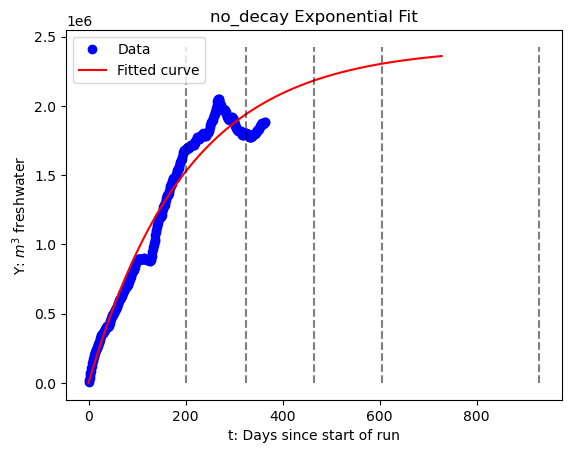

Optimized parameters:
A = 2569459 m^3
T = 228 days, 0.62 years
T_80pct = 1.00 years
T_90pct = 1.44 years
T_95pct = 1.87 years
T_99pct = 2.87 years


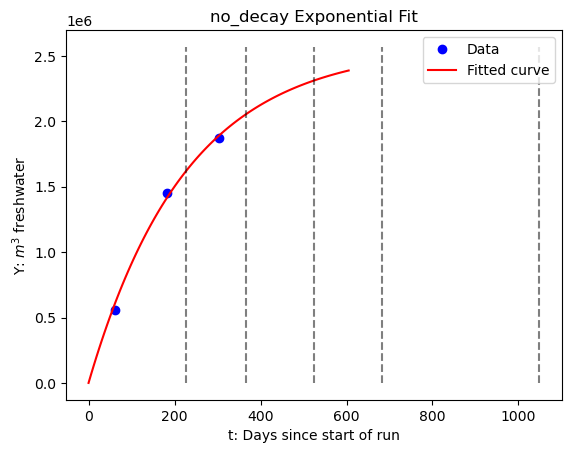

Optimized parameters:
A = 538271 m^3
T = 43 days, 0.12 years
T_80pct = 0.19 years
T_90pct = 0.27 years
T_95pct = 0.35 years
T_99pct = 0.55 years


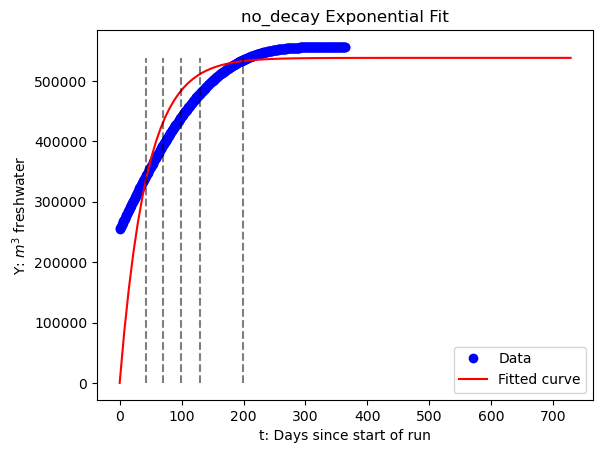

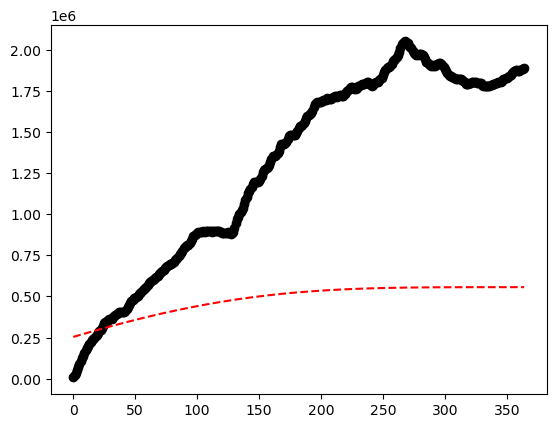

In [52]:
variable = 'no_decay'
days, vols = days_vols(idxs, ww_accumulated, variable)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_fraser_data, T_opt_fraser_data, T_95pct_fraser_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(ww_accumulated[variable])), Y_data=ww_accumulated[variable], region=variable)

chunk_size = 121
data_arr = ww_accumulated[variable][:-2].to_numpy()
resample_data = resample_mean(data_arr, chunk_size)
A_opt_fraser_mean, T_opt_fraser_mean, T_95pct_fraser_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, ww_accumulated[variable])
A_opt_fraser, T_opt_fraser, T_95pct_fraser = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(ww_accumulated[variable])), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(ww_accumulated[variable])), ww_accumulated[variable], 'ko')
plt.plot(np.arange(0, len(ww_accumulated[variable])), filtered_signal, 'r--')

### Concentration Plots

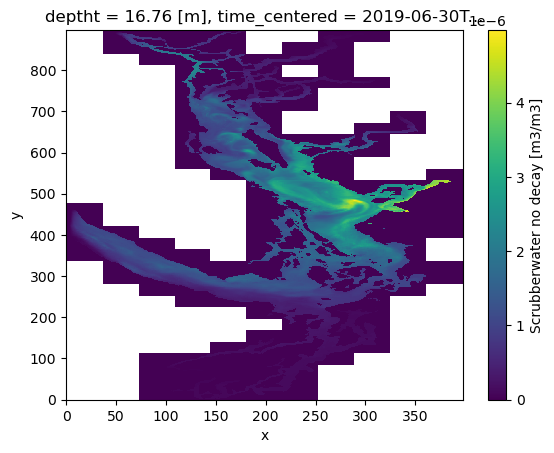

In [19]:
conc = ww_out.no_decay.isel(deptht=16, time_counter=180)
conc.plot()

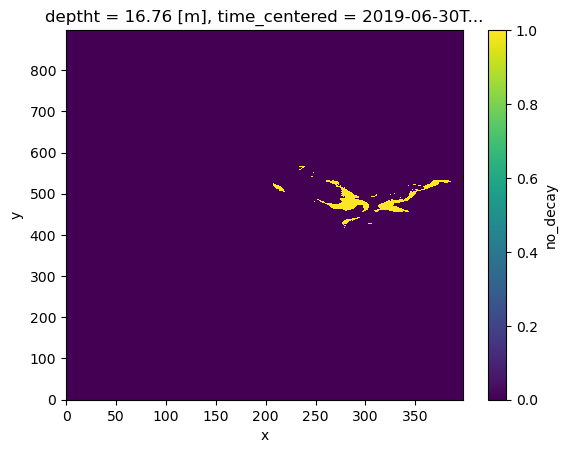

In [20]:
## concentration of concern is 0.0003%
bool = conc >= 0.0003/100
bool.plot()

In [21]:
oneday_vol = ww_out_oneday.no_decay * volume.rename({'depth':'deptht'})

In [22]:
oneday_vol.sum(dim='x').sum(dim='y').sum(dim='deptht')

<xarray.DataArray (time_counter: 1)>
array([7748.11415003])
Coordinates:
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2019-01-01T12:00:00

In [23]:
first_vol = ww_out.isel(time_counter=0).no_decay * volume.rename({'depth':'deptht'})

In [24]:
first_vol.sum(dim='x').sum(dim='y').sum(dim='deptht')

<xarray.DataArray ()>
array(7748.11415003)
Coordinates:
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2019-01-01T12:00:00

In [25]:
phys = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19_nn/SalishSea_1d_20190101_20190630_grid_T.nc')

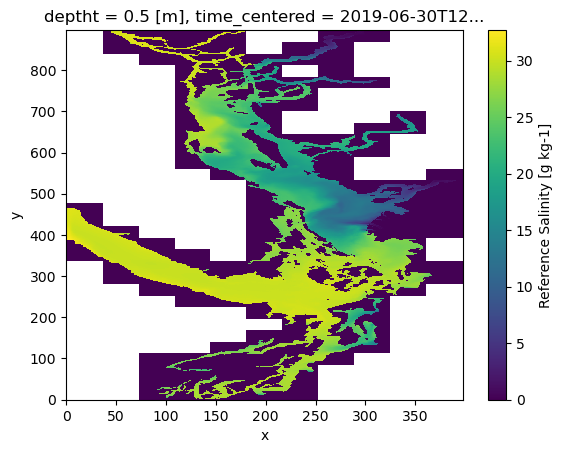

In [26]:
phys.isel(deptht=0, time_counter=180).vosaline.plot()

In [27]:
## depthwise sum of the whole domain, might need to do in a different notebook. save this output then read it back in

In [28]:
## turn the whole domain into concentrations, might need to do this in a different notebook. save this output and read it back in

In [29]:
## split into average concentration by layer slices. maybe 0-10m, 10-20m, 20-30m, 

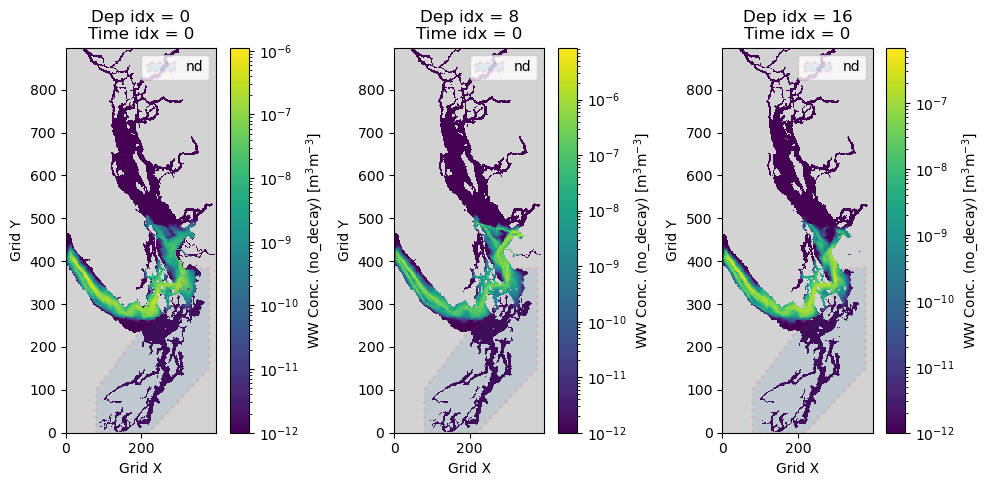

In [30]:
cmap = mpl.colormaps['viridis']
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig, ax1 = plt.subplots(1,3, figsize = (12, 5))
time_idx = 0

dep_idx = 0
washwater = np.ma.masked_array(ww_out_oneday.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[0].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
cb = fig.colorbar(colours, ax=ax1[0], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[0].add_patch(patch)
ax1[0].set_ylabel('Grid Y')
ax1[0].set_xlabel('Grid X')
ax1[0].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[0]);
ax1[0].legend()

dep_idx = 8
washwater = np.ma.masked_array(ww_out_oneday.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[1].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
cb = fig.colorbar(colours, ax=ax1[1], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[1].add_patch(patch)
ax1[1].set_ylabel('Grid Y')
ax1[1].set_xlabel('Grid X')
ax1[1].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[1]);
ax1[1].legend()

dep_idx = 16
washwater = np.ma.masked_array(ww_out_oneday.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[2].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
cb = fig.colorbar(colours, ax=ax1[2], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[2].add_patch(patch)
ax1[2].set_ylabel('Grid Y')
ax1[2].set_xlabel('Grid X')
ax1[2].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[2]);
ax1[2].legend()

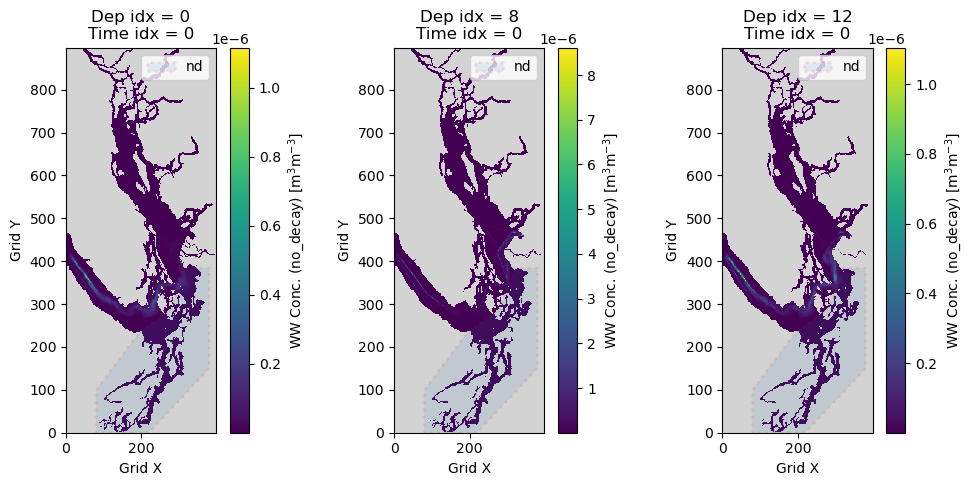

In [31]:
# cmap = cm.amp
cmap = mpl.colormaps['viridis']
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig, ax1 = plt.subplots(1,3, figsize = (12, 5))
time_idx = 0

dep_idx = 0
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
# colours = ax1[0].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
colours = ax1[0].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[0], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[0].add_patch(patch)
ax1[0].set_ylabel('Grid Y')
ax1[0].set_xlabel('Grid X')
ax1[0].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[0]);
ax1[0].legend()

dep_idx = 8
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[1].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[1], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[1].add_patch(patch)
ax1[1].set_ylabel('Grid Y')
ax1[1].set_xlabel('Grid X')
ax1[1].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[1]);
ax1[1].legend()

dep_idx = 12
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[2].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[2], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[2].add_patch(patch)
ax1[2].set_ylabel('Grid Y')
ax1[2].set_xlabel('Grid X')
ax1[2].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[2]);
ax1[2].legend()

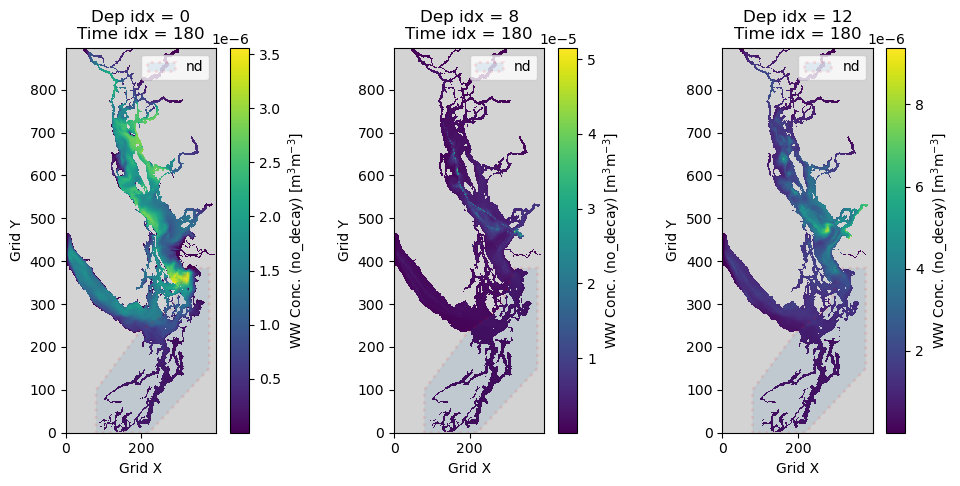

In [32]:
cmap = mpl.colormaps['viridis']
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig, ax1 = plt.subplots(1,3, figsize = (12, 5))
time_idx = 180

dep_idx = 0
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
# colours = ax1[0].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
colours = ax1[0].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[0], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[0].add_patch(patch)
ax1[0].set_ylabel('Grid Y')
ax1[0].set_xlabel('Grid X')
ax1[0].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[0]);
ax1[0].legend()

dep_idx = 8
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[1].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[1], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[1].add_patch(patch)
ax1[1].set_ylabel('Grid Y')
ax1[1].set_xlabel('Grid X')
ax1[1].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[1]);
ax1[1].legend()

dep_idx = 12
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx]) + 1e-12
colours = ax1[2].pcolormesh(washwater, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[2], label=r'WW Conc. (no_decay) [m$^3$m$^{-3}$]', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[2].add_patch(patch)
ax1[2].set_ylabel('Grid Y')
ax1[2].set_xlabel('Grid X')
ax1[2].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[2]);
ax1[2].legend()

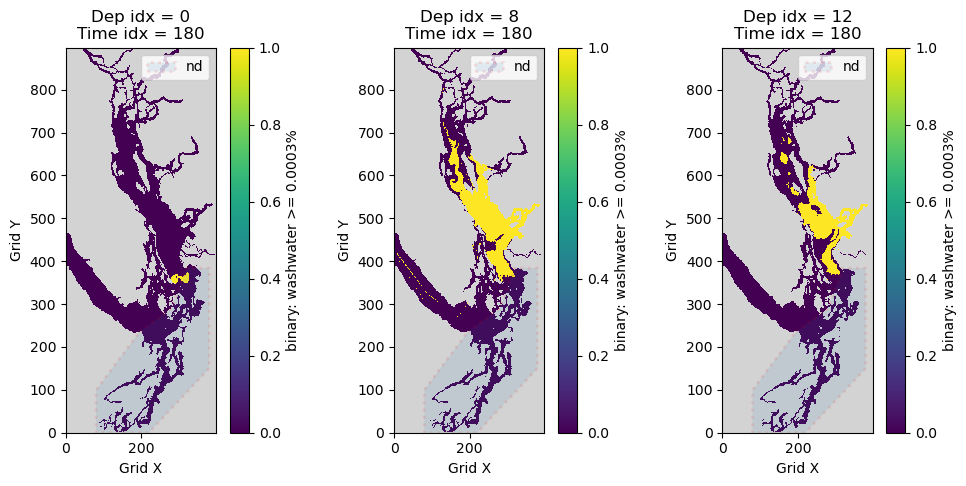

In [33]:
cmap = mpl.colormaps['viridis']
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig, ax1 = plt.subplots(1,3, figsize = (12, 5))
time_idx = 180

dep_idx = 0
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx])
bool = washwater >= 0.0003/100
# bool = washwater >= 1/100000
# colours = ax1[0].pcolormesh(washwater, cmap=cmap, norm=mcolors.LogNorm())
colours = ax1[0].pcolormesh(bool, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[0], label=r'binary: washwater >= 0.0003%', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[0].add_patch(patch)
ax1[0].set_ylabel('Grid Y')
ax1[0].set_xlabel('Grid X')
ax1[0].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[0]);
ax1[0].legend()

dep_idx = 8
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx])
bool = washwater >= 0.0003/100
colours = ax1[1].pcolormesh(bool, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[1], label=r'binary: washwater >= 0.0003%', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[1].add_patch(patch)
ax1[1].set_ylabel('Grid Y')
ax1[1].set_xlabel('Grid X')
ax1[1].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[1]);
ax1[1].legend()

dep_idx = 12
washwater = np.ma.masked_array(ww_out.isel(time_counter=time_idx, deptht=dep_idx).no_decay, mask=tmask[dep_idx])
bool = washwater >= 0.0003/100
colours = ax1[2].pcolormesh(bool, cmap=cmap)
cb = fig.colorbar(colours, ax=ax1[2], label=r'binary: washwater >= 0.0003%', location='right')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1[2].add_patch(patch)
ax1[2].set_ylabel('Grid Y')
ax1[2].set_xlabel('Grid X')
ax1[2].set_title('Dep idx = {}\nTime idx = {}'.format(dep_idx, time_idx))
viz_tools.set_aspect(ax1[2]);
ax1[2].legend()

#### Defns

In [34]:
matter_color = mcolors.to_hex(cm.matter(0.75))
haline_color = mcolors.to_hex(cm.haline(0.15))
thermal_color = mcolors.to_hex(cm.thermal(0.80))

### Plot: show the input data
Panel A: sum of all washwater volume over the domain
Panel B: histogram of individual washwater inputs
Panel C: histogram of temperature inputs
Panel D: histogram of salinity inputs

In [35]:
# fname = 'washwater_in'
# writervideo = animation.FFMpegWriter(fps=10)
# depth = 0 
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=0, depth=depth)), mask=tmask[0])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=150, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# viz_tools.set_aspect(ax);

# def newframe(frame_num):
#     washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=frame_num, depth=depth)), mask=tmask[depth])
#     colours.set_array(washwater.ravel())
#     dtime = pd.to_datetime(ww_in['time'].values[frame_num])
#     ax.set_title(str(dtime.date()))
#     viz_tools.set_aspect(ax);

# ani = FuncAnimation(fig, newframe, frames=len(ww_in['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/dfo-cd/animations/{}.mp4'.format(fname), writer=writervideo)

In [36]:
# fname = 'washwater_in_depth8.5'
# writervideo = animation.FFMpegWriter(fps=10)
# depth = 0
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=0, depth=depth)), mask=tmask[8])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=150, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# viz_tools.set_aspect(ax);

# def newframe(frame_num):
#     washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=frame_num, depth=depth)), mask=tmask[8])
#     colours.set_array(washwater.ravel())
#     dtime = pd.to_datetime(ww_in['time'].values[frame_num])
#     ax.set_title(str(dtime.date()))
#     viz_tools.set_aspect(ax);

# ani = FuncAnimation(fig, newframe, frames=len(ww_in['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/dfo-cd/animations/{}.mp4'.format(fname), writer=writervideo)

In [37]:
ww_in_sum = ww_in.washwater.sum(dim='time')

In [38]:
washwater_flat = ww_in.washwater.values.flatten()
temp_out_flat = ww_in.temp_out.values.flatten()
sal_out_flat = ww_in.sal_out.values.flatten()

washwater_flat = washwater_flat[~np.isnan(washwater_flat)]
temp_out_flat = temp_out_flat[~np.isnan(temp_out_flat)]
sal_out_flat = sal_out_flat[~np.isnan(sal_out_flat)]

In [39]:
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
# patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='-.')
# ax.add_patch(patch)

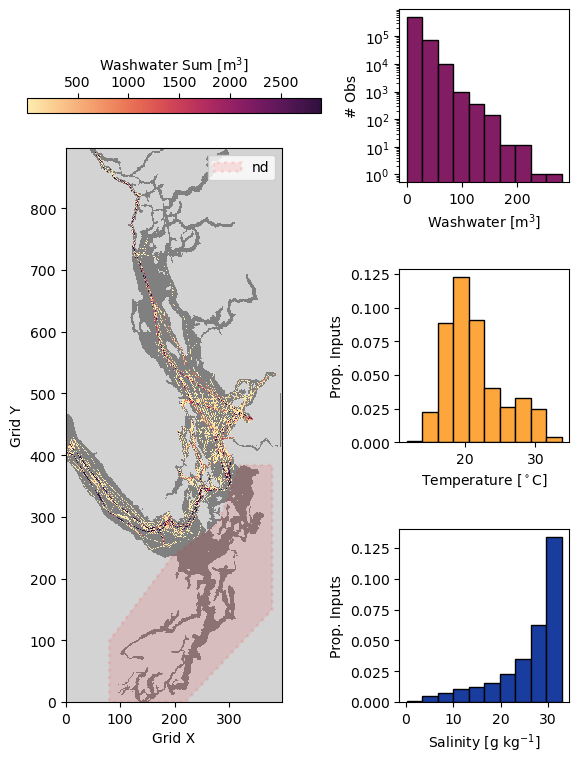

In [40]:
cmap = cm.matter
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig = plt.figure(figsize = (7, 9))
grid = plt.GridSpec(3,5, wspace=1.7, hspace=0.5)
ax1 = plt.subplot(grid[0:,0:3])
ax2 = plt.subplot(grid[0,3:])
ax3 = plt.subplot(grid[1,3:])
ax4 = plt.subplot(grid[2,3:])

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax1.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
cb = fig.colorbar(colours, ax=ax1, label=r'Washwater Sum [m$^3$]', location='top')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1.add_patch(patch)
ax1.set_ylabel('Grid Y')
ax1.set_xlabel('Grid X')
viz_tools.set_aspect(ax1);

ax2.hist(washwater_flat, 10, density=False, log=True, color=matter_color, edgecolor='k')
ax2.set_xlabel(r'Washwater [m$^3$]')
ax2.set_ylabel('# Obs')

ax3.hist(temp_out_flat, 10, density=True, log=False, color=thermal_color, edgecolor='k')
ax3.set_xlabel(r'Temperature [$^\circ$C]')
ax3.set_ylabel('Prop. Inputs')

ax4.hist(sal_out_flat, 10, density=True, log=False, color=haline_color, edgecolor='k')
ax4.set_xlabel(r'Salinity [g kg$^{-1}$]')
ax4.set_ylabel('Prop. Inputs')

ax1.legend()

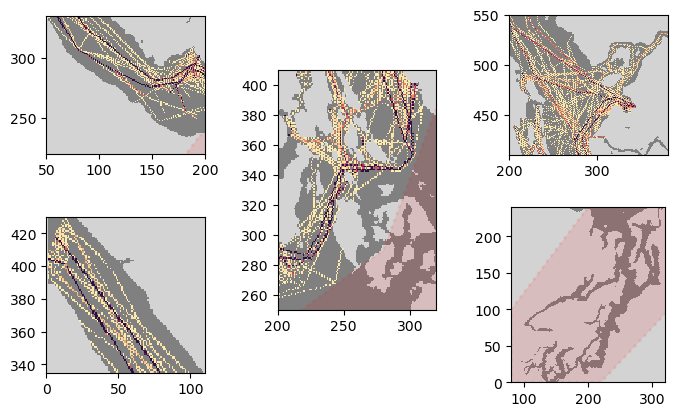

In [41]:
cmap = cm.matter
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig = plt.figure(figsize = (11, 5))
grid = plt.GridSpec(4,8, wspace=1.7, hspace=0.5)
ax1 = plt.subplot(grid[0:2,0:2])
ax2 = plt.subplot(grid[2:4,0:2])
ax3 = plt.subplot(grid[0:4:,2:4])
ax4 = plt.subplot(grid[0:2:,4:6])
ax5 = plt.subplot(grid[2:4:,4:6])

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax1.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax1, label=r'Washwater Sum [m$^3$]', location='left')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax1.add_patch(patch)
ax1.set_xlim([50,200])
ax1.set_ylim([220,335])
viz_tools.set_aspect(ax1);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax2.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax2, label=r'Washwater Sum [m$^3$]', location='left')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax2.add_patch(patch)
ax2.set_xlim([0,110])
ax2.set_ylim([335,430])
viz_tools.set_aspect(ax2);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax3.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax3, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax3.add_patch(patch)
ax3.set_xlim([200,320])
ax3.set_ylim([250,410])
viz_tools.set_aspect(ax3);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax4.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax4, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax4.add_patch(patch)
ax4.set_xlim([200,380])
ax4.set_ylim([410,550])
viz_tools.set_aspect(ax4);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum), mask=tmask[8])
colours = ax5.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax5, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax5.add_patch(patch)
ax5.set_xlim([80,320])
ax5.set_ylim([0,240])
viz_tools.set_aspect(ax5);

#### SRKW Habitat

In [42]:
crit_hab = gpd.read_file('crit_hab.gdb', layer='DFO_SARA_CH_EDH_EN')

/home/cdonaldson/conda_envs/analysis-2/lib/python3.12/site-packages/pyogrio/raw.py:200: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [43]:
orca = crit_hab['COMMON_E'] == 'Killer Whale'
crit_hab[orca]

,COMMON_E,POP_E,COMMON_F,POP_F,SCIENTIFIC,TAXON_E,ECO_TYPE_E,Waterbody,SARASTAT_E,CHSTATUS_E,COMMENT_E,LEAD_REG_E,SUP_REG_E,PROFILE_E,Area_Km2,Shape_Length,Shape_Area,geometry
864,Killer Whale,Northeast Pacific Northern Resident,Épaulard,résidente du nord du Pacifique Nord-Est,Orcinus orca,Mammals,Marine,Pacific Ocean/Océan Pacifique,Threatened,Final,None,Pacific,None,https://species-registry.canada.ca/index-en.ht...,7319.681360,1.924220e+06,1.774748e+10,"MULTIPOLYGON (((-13985503.47 6274700.411, -139..."
865,Killer Whale,Northeast Pacific Southern Resident,Épaulard,résidente du sud du Pacifique Nord-Est,Orcinus orca,Mammals,Marine,Pacific Ocean/Océan Pacifique,Endangered,Final,None,Pacific,None,https://species-registry.canada.ca/index-en.ht...,7496.738906,1.913499e+06,1.712860e+10,"MULTIPOLYGON (((-13985503.47 6274700.411, -139..."


### Plot: Timeseries of volume input to the model and timeseries of total present sum in the model
This will show different responses for the different half-lives